In [28]:
from langgraph.types import Command
from typing_extensions import TypedDict, Literal
from langgraph.graph import StateGraph, START, END
from langchain.chat_models import init_chat_model
from pydantic import BaseModel
import os
from dotenv import load_dotenv

load_dotenv(dotenv_path="../../.env")
llm = init_chat_model(
    "ollama:deepseek-r1:70b", base_url=os.environ.get("OLLAMA_BASE_URL")
)


smart_llm = init_chat_model(
    "ollama:gpt-oss:120b", base_url=os.environ.get("OLLAMA_BASE_URL")
)

average_llm = init_chat_model(
    "ollama:deepseek-r1:70b", base_url=os.environ.get("OLLAMA_BASE_URL")
)

dumb_llm = init_chat_model(
    "ollama:gemma3:latest", base_url=os.environ.get("OLLAMA_BASE_URL")
)


class State(TypedDict):
    question: str
    difficulty: str
    answer: str
    model_used: str


class DifficultyResponse(BaseModel):
    difficulty_level: Literal["easy", "medium", "hard"]

In [29]:
def dumb_node(state: State):
    response = dumb_llm.invoke(state["question"])
    print(dumb_llm.model_config)
    return {
        "answer": response.content,
        "model_used": dumb_llm.model,
    }


def average_node(state: State):
    response = average_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": dumb_llm.model,
    }


def smart_node(state: State):
    response = smart_llm.invoke(state["question"])
    return {
        "answer": response.content,
        "model_used": dumb_llm.model,
    }


def assess_difficulty(state: State):
    structured_llm = llm.with_structured_output(DifficultyResponse)
    response = structured_llm.invoke(
        f"""
        Assess the difficulty of this question

        Question:
        {state["question"]}

        - EASY: Simple facts, basic definitions, yes/no questions
        - MEDIUM: Requires explanation, comparison, analysis
        - HARD: Complex reasoning, multiple steps, deep expertise
        """
    )

    difficulty_level = response.difficulty_level

    if difficulty_level == "easy":
        goto = "dumb_node"
    elif difficulty_level == "medium":
        goto = "average_node"
    elif difficulty_level == "hard":
        goto = "smart_node"

    return Command(
        goto=goto,
        update={"difficulty": difficulty_level},
    )

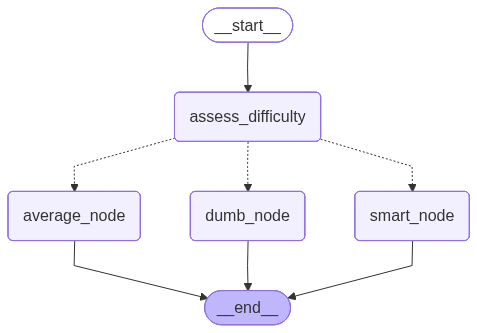

In [30]:
graph_builder = StateGraph(State)

graph_builder.add_node("dumb_node", dumb_node)
graph_builder.add_node("average_node", average_node)
graph_builder.add_node("smart_node", smart_node)
graph_builder.add_node(
    "assess_difficulty",
    assess_difficulty,
    destinations=(
        "smart_node",
        "average_node",
        "dumb_node",
    ),  # Just for graphics in the graph
)

graph_builder.add_edge(START, "assess_difficulty")
graph_builder.add_edge("dumb_node", END)
graph_builder.add_edge("smart_node", END)
graph_builder.add_edge("average_node", END)


graph = graph_builder.compile()

graph

In [32]:
graph.invoke({"question": "Capital of South Korea"})

{'extra': 'ignore', 'protected_namespaces': (), 'arbitrary_types_allowed': True}


{'question': 'Capital of South Korea',
 'difficulty': 'easy',
 'answer': "The capital of South Korea is **Seoul**. \n\nIt's a vibrant, bustling metropolis and the political, economic, and cultural heart of the country. \n\nDo you want to know anything more about Seoul?",
 'model_used': 'gemma3:latest'}

In [34]:
graph.invoke({"question": "Investment potential of Samsung Electronics in 2026"})

{'question': 'Investment potential of Samsung Electronics in 2026',
 'difficulty': 'medium',
 'answer': "**Investment Potential of Samsung Electronics in 2026: A Comprehensive Analysis**\n\n**1. Industry Overview:**\nSamsung Electronics operates across multiple sectors, including semiconductors, smartphones, home appliances, and more. The tech industry's growth, driven by AI, 5G, and emerging technologies like quantum computing, positions Samsung strategically for potential growth.\n\n**2. Semiconductor Division:**\n- **Market Demand:** High demand for advanced chips in AI, data centers, and IoT devices.\n- **Innovation:** Samsung's investment in cutting-edge semiconductor technology, including 3D stacking and EUV lithography, could drive market leadership.\n- **Competitive Edge:** Early involvement in 6G research might provide future advantages.\n\n**3. Smartphone Market:**\n- **Saturated Markets:** Growth opportunities lie in emerging markets and innovation like foldable phones and 5